#RELATÓRIO TÉCNICO
Quemuel Alves Nassor - 828461

# Importações

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from math import *
import numpy as np
import cv2 as cv
import glob
import os

# Declaração de métodos e funções

In [ ]:
# Função para identificar contorno
def calc_contornos(img_file):
  contornos, ordem = cv.findContours(img_file,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
  return contornos

# Função para calcular métricas de diametro
def calc_diametro(img_file):
  contornos, ordem = cv.findContours(img_file,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
  diametro = np.sqrt(4*cv.contourArea(contornos[0])/np.pi)
  return diametro

# Função para calcular métricas de perimetro
def calc_perimetro(img_file):
  contornos = calc_contornos(img_file)
  perimetro = cv.countNonZero(cv.Canny(img_file,50,100))
  return perimetro

# Função para calcular métricas de area
def calc_area(img_file):
  area = cv.countNonZero(img_file)
  return area

# Função para calcular métricas de compacidade
def calc_compacidade(img_file):
  area = calc_area(img_file)
  perimetro = calc_perimetro(img_file)
  compacidade = np.square(perimetro)/area
  return compacidade

# Função para calcular métricas de excentricidade
def calc_excentricidade(img_file):
  contornos = calc_contornos(img_file)
  excentricidade = 0.00

  if len(contornos) != 0:
    for cont in contornos:
      if len(cont) > 5:
          (x,y), (eixoMenor,eixoMaior),angulo = cv.fitEllipse(cont)
          if (eixoMaior/eixoMenor > excentricidade):
            excentricidade = eixoMaior/eixoMenor

  return excentricidade

# Função para calcular métricas de retangularidade
def calc_retangularidade(img_file):
  contornos = calc_contornos(img_file)
  area = calc_area(img_file)
  x,y, largura, altura = cv.boundingRect(contornos[0])
  retangularidade = area/(largura * altura)
  return retangularidade

# Função para calcular métricas de solidez
def calc_solidez(img_file):
  contornos = calc_contornos(img_file)
  area = cv.contourArea(contornos[0])
  fechoconvexo = cv.contourArea(cv.convexHull(contornos[0]))
  solidez = area/fechoconvexo
  return solidez

def melhorar_img(img_file):

  # Reduz o ruído da imagem
  kernel = np.ones((3,3),np.uint8)    
  img3 = cv.morphologyEx(img_file, cv.MORPH_OPEN, kernel, iterations = 2)
  
  # Dilata a imagem para melhorar as bordas
  median = cv.dilate(img3, kernel, iterations=1)

  # Aplica blur para melhorar a aparência
  median = cv.medianBlur(median,9)

  return median

In [ ]:
# Função para ler as propriedades das imagens
def get_propriedades_imagens(img_rotuladas):

  diametro = list()
  perimetro = list()
  area = list()
  compacidade = list()
  excentricidade = list()
  retangularidade = list()
  solidez = list()
  nome = list()

  for item in img_rotuladas:
    for img in item[1]:

      # Efetua a leitura da imagem
      img_file = cv.cvtColor(cv.imread(img),cv.COLOR_BGR2GRAY)
      img_file = melhorar_img(img_file)

      # Calcula as métricas da imagem
      diametro.append(calc_diametro(img_file))
      perimetro.append(calc_perimetro(img_file))
      area.append(calc_area(img_file))
      compacidade.append(calc_compacidade(img_file))
      excentricidade.append(calc_excentricidade(img_file))
      retangularidade.append(calc_retangularidade(img_file))
      solidez.append(calc_solidez(img_file))
      nome.append(item[0])  
      
  # Montando dataset    
  dataset = {
      'Diâmetro': diametro,
      'Perímetro': perimetro,
      'Área': area,
      'Compacidade': compacidade,
      'Excentricidade': excentricidade,
      'Retangularidade': retangularidade,
      'Solidez': solidez,
      'Nome': nome
      } 

  if(os.path.isfile('./fruits_dataset.csv')):
    !rm ./fruits_dataset.csv

  # Gravando dataset no arquivo csv
  dataset = pd.DataFrame(data=dataset)
  dataset.to_csv(path_or_buf='./fruits_dataset.csv', sep=';', index=False)

  return dataset.head()

# Aquisição e rotulação

Resultado do tratamento das imagens: 


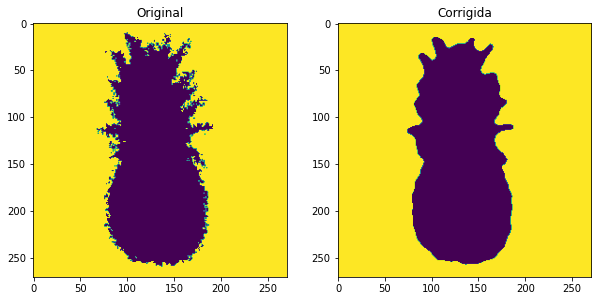





Dataset gerado: 


,Diâmetro,Perímetro,Área,Compacidade,Excentricidade,Retangularidade,Solidez,Nome
0,304.662375,1014,36121,28.465325,1.108207,0.491837,1.0,Maçãs
1,304.662375,1008,36954,27.495373,2.244793,0.503179,1.0,Maçãs
2,304.662375,1020,36408,28.576137,2.254603,0.495745,1.0,Maçãs
3,304.662375,968,36612,25.593357,1.107763,0.498523,1.0,Maçãs
4,304.662375,987,36428,26.742314,1.133200,0.496017,1.0,Maçãs


In [ ]:
origem = "./drive/MyDrive/root/frutas_dataset/*.bmp"

# Query das imagens para processamento
imagens = glob.glob(origem)
imagens.sort()


# Segmentação e rotulação
imagens_rotuladas = (
  [ "Maçãs"   , imagens[0:30]    ],
  [ "Abacaxis", imagens[30:60]   ],
  [ "Bananas" , imagens[60:90]   ],
  [ "Pêssegos", imagens[90:120]  ],
  [ "Pitangas", imagens[120:150] ],
  [ "Laranjas", imagens[150:180] ],
  [ "Morangos", imagens[180:210] ],
  [ "Pêras"   , imagens[210:240] ],
  [ "Limãos"  , imagens[240:270] ],
  [ "Uvas"    , imagens[270:300] ],
)

# Resultado do tratamento da imagem
print("Resultado do tratamento das imagens: ",end='\n')
exemplo = imagens_rotuladas[1][1][20]
amostra = cv.cvtColor(cv.imread(exemplo),cv.COLOR_BGR2GRAY) 
plt.figure(figsize=(10,10)) 
plt.subplot(121), plt.imshow(amostra), plt.title('Original')
plt.subplot(122), plt.imshow(melhorar_img(amostra)), plt.title('Corrigida')
plt.show()

# Adquire as propriedades de cada imagem e salva no dataset
print("\n\n\n\nDataset gerado: ",end='\n')
get_propriedades_imagens(imagens_rotuladas)


# Classificação e resultados

In [ ]:
dataset = pd.read_csv('fruits_dataset.csv', sep=';')

# separando características e rótulos
dados = dataset.iloc[:,0:7]     
rotulos = dataset.iloc[:,7]    

# Normalização
normalizar = StandardScaler()
normalizar.fit(dados)
dados = normalizar.transform(dados)

# treinamento e teste
dadosTrain, dadosTest, rotulosTrain, rotulosTest = train_test_split(dados,rotulos,test_size=0.30, random_state=25)

# Classificação
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(dadosTrain, rotulosTrain)
rotulos = knn.predict(dadosTest)

# Acurácia
acuracia = accuracy_score(rotulosTest, rotulos)
print('Acurácia: {0:.2f}%\n\n'.format(acuracia*100))

# Matriz confusão
print("Matriz confusão:",end='\n')
pd.crosstab(rotulosTest,rotulos,rownames=['True'],colnames=['Predição'],margins=True)


Acurácia: 95.56%


Matriz confusão:


Predição,Abacaxis,Bananas,Laranjas,Limãos,Maçãs,Morangos,Pitangas,Pêras,Pêssegos,Uvas,All
True,,,,,,,,,,,
Abacaxis,9,0,0,0,0,0,0,0,0,0,9
Bananas,0,9,0,0,0,0,0,0,0,0,9
Laranjas,0,0,10,0,0,0,0,0,0,0,10
Limãos,0,0,0,4,0,0,0,0,0,0,4
Maçãs,0,0,0,0,10,0,0,0,0,0,10
Morangos,0,0,0,0,0,9,0,1,0,0,10
Pitangas,0,1,0,0,0,0,8,0,0,0,9
Pêras,0,0,0,0,0,1,0,6,0,0,7
Pêssegos,0,0,0,0,0,0,0,0,11,0,11
